# Project Freedom - Only Cats



Harrison Stark, Kohki Taniguchi

The purpose of this notebook/program is to take in a video as input and extract only the parts of the video in which a cat is found. Cats in the video will be detected using a CNN that implements the EfficientNetB0 network and is trained on a dataset of natural images, of which one of the categories is cats. The dataset can be found [here](https://www.kaggle.com/datasets/prasunroy/natural-images).

In [ ]:
# los imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import matplotlib.pyplot as plt
import skvideo.io
from sklearn.utils import shuffle
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input

# File Prep
All files used are managed in a personal Google Drive. The dataset and video input/output are all located in the drive. All input will be converted to dimensions 224x224, as this is the size of input EfficientNetB0 was trained on for the ImageNet dataset. When loading the dataset into training and testing data, in addition to the image and category, a one-hot encoded list is generated which will be how the network comprehends categories.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def exists(var_name):
    return var_name in locals() or var_name in globals()

In [ ]:
types = ["airplane", "car", "cat", "dog", "flower", "fruit", "motorbike", "person"] # types of images
num_ims = len(types)
path = "/content/drive/MyDrive/Dataset/data/natural_images"
lw = 224 # length and width
dim = (lw, lw)

In [ ]:
def load_images():
    images = []
    labels = []
    for i, t in enumerate(types): # go through all types
        for file in os.listdir(path + "/" + t): # go through all images in folder of types
            labels.append(i)
            im = Image.open(path + "/" + t + "/" + file)
            im_resized = im.resize(dim)
            im_np = np.array(im_resized)
            images.append(im_np)
    return (images, labels)

In [ ]:
if exists("images") == False or exists("labels") == False:
    (images, labels) = load_images()
elif np.array(images).shape[0] != 6899 and np.array(labels).shape[0] != 6899:
    (images, labels) = load_images()

In [ ]:
images = np.array(images)
labels = np.array(labels)
labels_cat = keras.utils.to_categorical(labels) # one-hot encoded
print(images.shape)
print(labels.shape)
print(labels_cat.shape)

(6899, 224, 224, 3)
(6899,)
(6899, 8)


In [ ]:
(images, labels, labels_cat) = shuffle(images, labels, labels_cat, random_state = 69) # cupid shuffle
x_train = images[:5500]
x_test = images[5500:]
y_train = labels[:5500]
y_test = labels[5500:]
y_train_cat = labels_cat[:5500]
y_test_cat = labels_cat[5500:]

dog


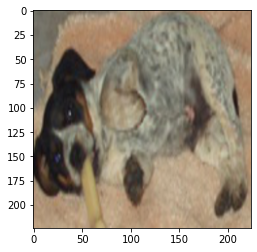

flower


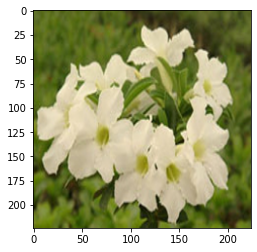

cat


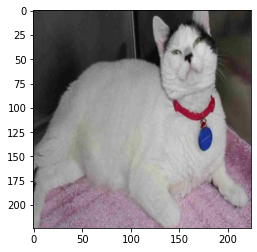

motorbike


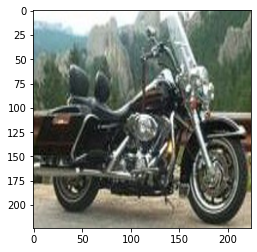

cat


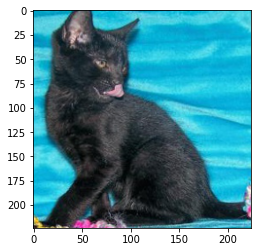

motorbike


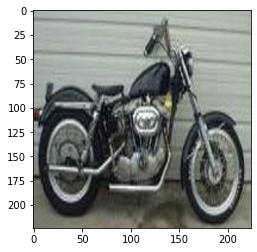

car


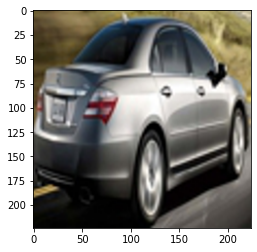

cat


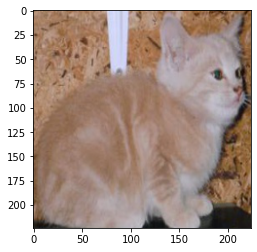

In [ ]:
for i in range(8):
    plt.imshow(images[i])
    print(types[labels[i]])
    plt.show()

# Building the model
As stated earlier, the CNN will implement the EfficientNetB0 network along with a few extra layers that will be trained by an augmented version of the natural images dataset. After running the program for the first time, the weights will be saved so that the network does not have to be retrained every time.

In [ ]:
aug_layers = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
def build_model(num_classes):
    model = Sequential()
    model.add(Input(shape=(224, 224, 3)))
    model.add(aug_layers)
    en = keras.applications.EfficientNetB0(include_top=False, weights="imagenet")
    en.trainable = False
    model.add(en)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.15, name="top_dropout"))
    model.add(layers.Dense(num_classes, activation="softmax"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
model = build_model(num_ims);
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                        

In [ ]:
checkpoint_path = path + "/weights.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
if os.path.isfile(checkpoint_path + ".data-00000-of-00001"):
    weights = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(weights)
    loss, acc = model.evaluate(x_test, y_test_cat, verbose = 2)
    print("Weights reuploaded, new loss:", loss)
    print("Weights reuploaded, new accuracy:", acc)
else:
    model.fit(x_train, y_train_cat, batch_size = 256, epochs = 4, validation_data = (x_test, y_test_cat));
    model.save_weights(checkpoint_path)

44/44 - 86s - loss: 0.0201 - accuracy: 0.9964 - 86s/epoch - 2s/step
Weights reuploaded, new loss: 0.020064078271389008
Weights reuploaded, new accuracy: 0.9964260458946228


1/1 [==============================] - 2s 2s/step
[[4.1807049e-05 4.9710798e-06 9.9972302e-01 2.0918781e-04 9.4631778e-06
  7.5294142e-06 8.1126341e-09 4.0858595e-06]]
cat


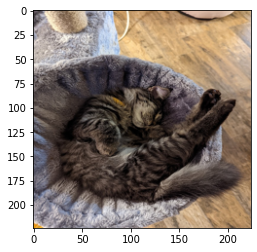

In [ ]:
imag = Image.open("/content/drive/MyDrive/Dataset/2.jpg")
imag_resized = imag.resize(dim)
imag_np = np.array(imag_resized)
imag_np = imag_np[:,:,:3]
imag_np = imag_np.reshape(1, 224, 224, 3)
pred = model.predict(imag_np) # proof of concept, can see cat in whole image
print(pred)
plt.imshow(imag_np.reshape(224, 224, 3))
print(types[np.argmax(pred)])
plt.show()

# Detecting Cats
Just as images are represented as NumPy arrays during computation, video input is converted to an array of images for each frame. To have the network detect cats in an image/video input of any dimension (important as videos are most often not square), the input is split into 224x224 subimages that are fed into the network individually. If the full image does not divide evenly, the 224x224 subimage is the right-most and/or bottom-most 224x224 area.

The program then aggregates the output for every subimage and sees if there is at least one subimage where a cat is detected with a certain threshold of confidence (currently it is 98.5%). If this is true, the entire image is labeled as having a cat. For a video, this is done for every frame.

The final step for cropping the video is to account for small gaps where the network somehow did not detect a cat in between frames that were mostly detected as having a cat. After all, it does not make logical sense for the cat to be flickering in and out of the video for fractions of seconds at a time. Once this is complete, the cropped video is saved on the Google Drive.

In [ ]:
def subimage_generator(image, lw):
    cat_arr = []
    l = image.shape[1]
    w = image.shape[0]
    for i in np.arange(0, l, lw):
        for j in np.arange(0, w, lw):
            if (j+lw < w) & (i+lw < l):
                im = Image.fromarray(image[j:j+lw, i:i+lw, :])
            elif (j+lw >= w) & (i+lw < l):
                im = Image.fromarray(image[w-lw-1:w-1, i:i+lw, :])
            elif (j+lw < w) & (i+lw >= l):
                im = Image.fromarray(image[j:j+lw, l-lw-1:l-1, :])
            else:
                im = Image.fromarray(image[w-lw-1:w-1, l-lw-1:l-1, :])
            im = im.resize((lw, lw))
            arr = np.array(im)
            cat_arr.append(arr)
    '''im = Image.fromarray(image[0:w//2, 0:w//2, :]) # top left
    im = im.resize((lw, lw))
    arr = np.array(im)
    cat_arr.append(arr)
    im = Image.fromarray(image[0:w//2 - 1, w//2:w - 1, :]) # top right
    im = im.resize((lw, lw))
    arr = np.array(im)
    cat_arr.append(arr)
    im = Image.fromarray(image[l - w//2:w - 1, 0:w//2, :]) # bottom left
    im = im.resize((lw, lw))
    arr = np.array(im)
    cat_arr.append(arr)
    im = Image.fromarray(image[l - w//2:w - 1, w//2:w - 1, :]) # bottom right
    im = im.resize((lw, lw))
    arr = np.array(im)
    cat_arr.append(arr)'''
    return cat_arr

In [ ]:
def contains_cat(preds):
    for i in preds:
        if types[np.argmax(i)] == "cat" and float(i[np.argmax(i)]) >= .99:
            # print(str(float(i[np.argmax(i)])) + "%")
            return True
    return False

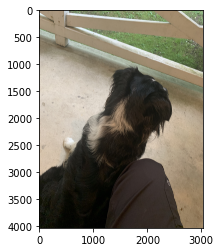

8/8 [==============================] - 15s 2s/step
no cat


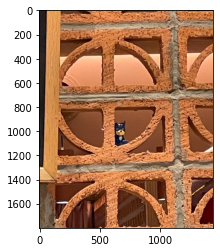

2/2 [==============================] - 4s 2s/step
no cat


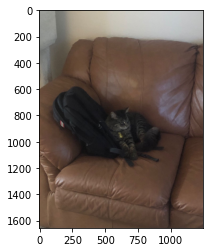

2/2 [==============================] - 3s 978ms/step
has cat


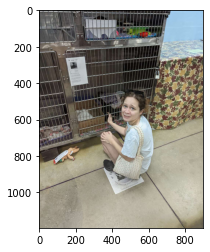

1/1 [==============================] - 2s 2s/step
no cat


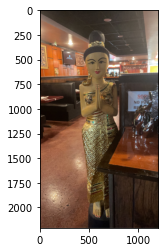

2/2 [==============================] - 4s 2s/step
no cat


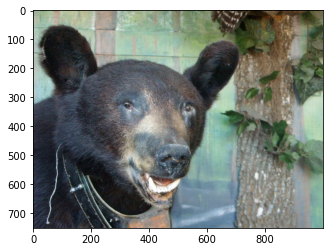

1/1 [==============================] - 1s 1s/step
has cat


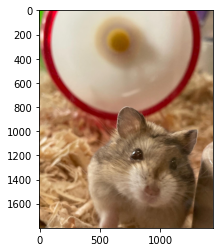

2/2 [==============================] - 4s 2s/step
has cat


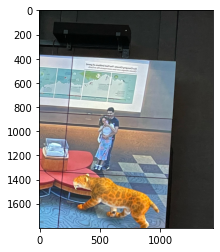

2/2 [==============================] - 4s 2s/step
has cat


In [ ]:
for catfile in os.listdir("/content/drive/MyDrive/Dataset/tester"): # proof of concept
    cat_im = Image.open("/content/drive/MyDrive/Dataset/tester/" + catfile)
    #cat_im = cat_im.resize((1920, 1080))
    cat_im = np.array(cat_im)[:,:,:3]
    plt.imshow(cat_im)
    plt.show()
    cat_array = np.array(subimage_generator(cat_im, lw))
    preds = model.predict(cat_array);
    print("has cat" if contains_cat(preds) else "no cat")

In [ ]:
cat_vid = skvideo.io.vread("/content/drive/MyDrive/Dataset/cat_video.mp4")
print(cat_vid.shape)
vid_frames = []
for i in range(cat_vid.shape[0]): # proof of concept
    cat_frame = cat_vid[i][:,:,:3]
    #plt.imshow(cat_frame)
    #plt.show()
    cat_array = np.array(subimage_generator(cat_frame, lw))
    preds = model.predict(cat_array)
    if contains_cat(preds):
        #print("has cat")
        vid_frames.append(1)
    else:
        #print("no cat")
        vid_frames.append(0)
vid_frames = np.array(vid_frames)
print(vid_frames)

(63, 720, 1280, 3)
1/1 [==============================] - 1s 1s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [ ]:
pot_gap = False
roller = 0
true_frames = []
for i in range(vid_frames.shape[0]):
    if vid_frames[i] == 0:
        if pot_gap == True and roller <= 10:
            roller = roller + 1
        else:
            true_frames.append(0)
            roller = 0
            pot_gap = False
    elif vid_frames[i] == 1:
        if pot_gap == True and roller != 0:
            true_frames.append(1)
            for j in range(roller):
                true_frames.append(1)
            roller = 0
        else:
            true_frames.append(1)
            pot_gap = True
if roller != 0:
    for j in range(roller):
        true_frames.append(1)
true_frames = np.array(true_frames)
print(true_frames)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
new_video = cat_vid[true_frames == True]
print(new_video.shape)

(36, 720, 1280, 3)


In [ ]:
skvideo.io.vwrite("/content/drive/MyDrive/Dataset/cat_video_out.mp4", new_video)

# Final Videos
> https://drive.google.com/file/d/1M3agyXBfn6GnaxLbd7e9eNttlKs_H6O_/view?usp=sharing
> https://drive.google.com/file/d/1bGelCayZj2F6CU8J7aAQLTp62JzlcmxR/view?usp=sharing

# Paper
> https://docs.google.com/document/d/1kjP-O4XRWjYsHXGRQgLc1p84ur1AHOims_gvijQ2xLU/edit?usp=drivesdk